# Day 5  | First week task

Lets put our knowledge into action by tackling following tasks: 


- Load time lapse fluorescence data from Matlab file "task1.mat" that is in the main course folder. Data are stored in two matrices: *x_norm* contains trajectories and *t* is a time vector

- Plot (with labels) example cell tracetories | Tip: transpose the loaded data to get first dimension the same

- Find peaks in each trajectories usin scipy library functions | Tip: Search for suitable functions in scipy manual

- Calculate amplitude and period of oscillations | Tip: the period of oscillation is a distance between peaks in a single cell trajectory

- Draw histograms of period distribution

- Plot amplitude vs period with labels 

- Select ten cell trajectiories with the smallest periods and plot those as a heat map 

- Perform frequency analysis using FFT Fourier transformation and identify a dominant frequency in the signal


## Yaiza Arnáiz Alcácer

In [1]:
#import necessary tools, please add yourself here whatever you think you might need to solve the task

#basics
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt #I don't like write plotter every time
from scipy.signal import find_peaks
#!pip install seaborn 
import seaborn as sns #I found this on internet and I like how the plots look like 
from scipy.fftpack import fft
import json


data = sio.loadmat('./task1.mat')
cell_data = np.transpose(data['x_norm'])
t = np.transpose(data['t'])

In [17]:
#Looking the exercises, all need the same arguments so lets define a class and the functions we need 
class Oscillation:

    def __init__(self, matrix_trajectories, time):
        filtering = np.argwhere(np.all(matrix_trajectories[..., :] == 0, axis=0))
        self.trajectories = np.delete(matrix_trajectories, filtering, axis=1)  # remove the cells that don't have any trajectory.
        self.time = time
        self.peaks = self.extract_peaks()   # I need almost every time the peaks

    def plot_trajectories(self):
        """
        :return: Figure with 5 random cell trajectories
        """
        random_index = np.random.choice(self.trajectories.shape[1], 5, replace=False)
        for _ in random_index:
            random_cells = self.trajectories[:, _]
            plt.plot(self.time, random_cells, '-o', label='Cell ' + str(_))
        plt.xlim(0, 150)
        plt.title('Trajectories of Cells')
        plt.xlabel('Time (min)')
        plt.ylabel('Fluorescence (a.u.)')
        plt.legend(loc='best', shadow=True)
        plt.savefig("5_cell_random_trajectories.pdf", bbox_inches='tight') #save the figure for the publication
        plt.show()

    def extract_peaks(self):
        """
        :return: Peaks fount in every trajectory.
        """
        peaks = [find_peaks(trajectory_column)[0] for trajectory_column in self.trajectories.T]
        return peaks

    def amplitude_peaks(self):
        """
        :return: The peak value that it is the amplitude of the peak.
        """
        amplitude = [trajectory_column[peak] for trajectory_column, peak in zip(self.trajectories.T, self.peaks)]
        return amplitude

    def amplitude_mean(self):
        """
        :return: The mean of the amplitude in every cell
        """
        amplitude = self.amplitude_peaks()
        amplitude_m = [np.mean(amplitude_value) if amplitude_value.size > 1 else 'Is not an average, the amplitude {} is from just one peak '.format(amplitude_value) for amplitude_value in amplitude]
        return amplitude_m

    def period_oscillations(self):
        """
        :return: The  mean of the times values of the peaks and period mean in every cell
        """
        times = [self.time[peak] for trajectory_column, peak in zip(self.trajectories.T, self.peaks)]
        period_m = [(peak_times[-1] - peak_times[0]) / (peak_times.size - 1) if peak_times.size > 1 else 'There is not period' for peak_times in times]
        return times, period_m

    def period(self):
        """
        :return: If you want to use only the numerical values of period oscillations
        """
        _, period_m = self.period_oscillations()
        period_m_values = [_ for _ in period_m if isinstance(_, np.ndarray)]
        return period_m_values

    def amplitude(self):
        """
        :return: If you want to use only the numerical values of the amplitude
        """
        amplitude_m = self.amplitude_mean()
        amplitude_m_values = [_ for _ in amplitude_m if isinstance(_, float)]
        return amplitude_m_values

    def trajectories_info(self):
        """
        :return: Return the trajectories of every cell.
        """
        times, _ = self.period_oscillations()
        trajectories_m = [trajectory if peak_times.size > 1 else 'This trajectory is not an oscillation' for trajectory, peak_times in zip(self.trajectories.T, times)]
        return trajectories_m

    def plot_period_distribution(self):
        """
        :return: Plot the period distribution.
        """
        period_values = self.period()

        sns.distplot(x=period_values, hist=True, kde=True,
                     kde_kws={"color": "g", "alpha": 0.3, "linewidth": 1, "shade": True}).set_title('Period distribution')
        plt.savefig("Period distribution.pdf", bbox_inches='tight')
        plt.show()
        

    def plot_components_oscillations(self):
        """
        :return: Plot the amplitude vs the period
        """
        amplitude_values = self.amplitude()
        period_values = np.asarray(self.period()).flatten()
        fig = sns.scatterplot(x=period_values, y=amplitude_values, alpha=0.4)
        fig.set_title('Amplitude vs Period')
        plt.ylabel('Amplitude')
        plt.xlabel('Period (min)')
        plt.savefig("Amplitude vs Period.pdf", bbox_inches='tight')
        plt.show()
        

    def create_array_trajectories(self):
        """
        :return: Create an array with the trajectories that are periodic.
        """
        trajectories_m = self.trajectories_info()
        trajectories_m_values = [_ for _ in trajectories_m if isinstance(_, np.ndarray)]
        trajectories_array = np.array(trajectories_m_values)
        return trajectories_array, trajectories_m_values

    def plot_heatmap(self):
        """
        :return: Plot a heatmap only with the 10 trajectories with the lowest period mean.
        """
        period_values = self.period()
        trajectories_array, _ = self.create_array_trajectories()
        numeric_period = list(np.array(period_values).ravel())
        c = np.array(numeric_period)
        last_index = np.argpartition(c, 10)[:10]
        lowest_trajectories = trajectories_array[last_index]
        all_zeros = np.all(lowest_trajectories[:, -1] == 0)
        time = self.time
        while all_zeros:   # Cut all the columns of the end if doesn't have any value.
            lowest_trajectories = np.delete(lowest_trajectories, -1, axis=1)
            all_zeros = np.all(lowest_trajectories[:, -1] == 0)
            time = time[:-1]
        fig, ax = plt.subplots()
        ax.imshow(lowest_trajectories, aspect='auto')

        # We want to show n = 10 ticks...
        n = 9
        z = len(time)/n
        ticklabels = np.array([int(z * _) for _ in range(n)] + [len(time) - 1])
        ax.set_xticks(ticklabels)
        cells = ['Cell {}'.format(i) for i in last_index]
        ax.set_yticks(np.arange(len(cells)))
        # and label them with the respective list entries
        ax.set_xticklabels(time.flatten().astype(np.int32)[ticklabels])
        ax.set_yticklabels(cells)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax.set_title("Cell trajectories of the ten lowest period oscillation (Time in min)")
        plt.xlabel('Time (min)')
        plt.ylabel('Fluorescence (a.u.)')
        plt.savefig("HeatMap.pdf", bbox_inches='tight')
        plt.show()

    def frequency_analysis(self):
        """
        :return: Do the fourier transformation of the trajectories.
        """
        trajectories_array, _ = self.create_array_trajectories()
        period = self.time[1] - self.time[0]
        f = trajectories_array
        number_samples = trajectories_array.shape[1]
        yf = fft(f)
        xf = np.linspace(0.0, 1.0/(2.0*period), number_samples//2)
        return yf, xf, number_samples

    def plot_frequency_analysis(self):
        """
        :return: Plot the Frequency percentiles to analyse were is the dominant frequency
         and plot as well the Fourier Transformation of every trajectory.
        """
        yf, xf, number_samples = self.frequency_analysis()
        for p in [10, 25, 50, 75, 90]:
            percentile = np.percentile(np.abs(yf), p, axis=0)
            plt.plot(xf, 2.0/number_samples * percentile[0:number_samples//2], label='{}th Percentile'.format(p))
        plt.title('Frequency percentiles')
        plt.xlabel('Power(signal)')
        plt.ylabel('FFT Fourier Transformation')
        plt.legend(loc='best', shadow=True)
        plt.savefig("Frequency percentiles.pdf", bbox_inches='tight')
        plt.show()
        for y_values in yf:
            plt.plot(xf, 2.0/number_samples * np.abs(y_values[0:number_samples//2]), alpha=0.4)
        plt.xlabel('Frequency')
        plt.ylabel('Power(signal)')
        plt.title("FFT Fourier Transformation")
        plt.savefig("FFT Fourier Transformation.pdf", bbox_inches='tight')
        plt.show()
                    


In [18]:
#Now we already wrote our pipeline is time to define our object, call the functions, store our data and do the plots 
o = Oscillation(cell_data, t)

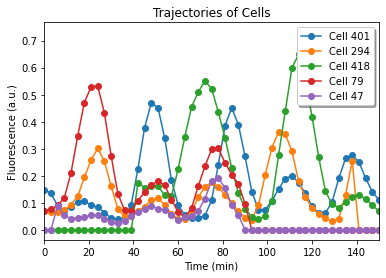

In [19]:
o.plot_trajectories()


C:\Users\yaiza\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


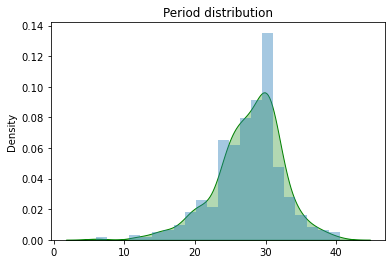

In [20]:
o.plot_period_distribution()

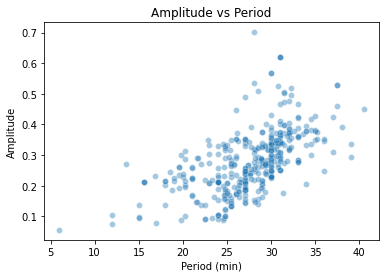

In [21]:
o.plot_components_oscillations()

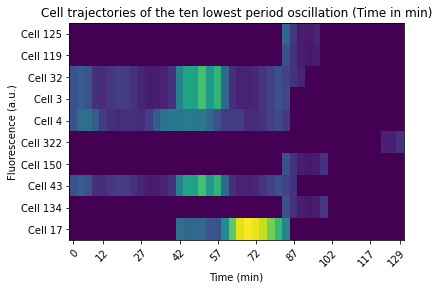

In [22]:
o.plot_heatmap()

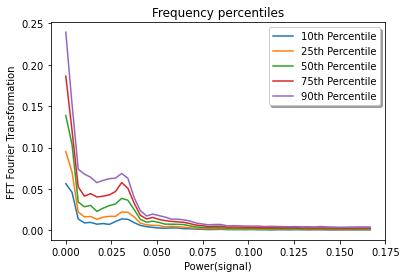

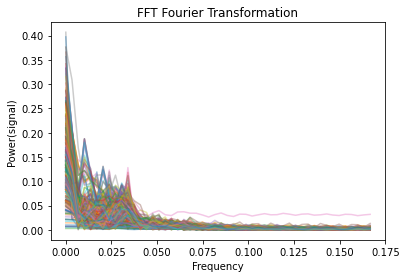

In [23]:
o.plot_frequency_analysis()

In the figure of the percentiles we have a good representation of our data, and we can stimate that the the dominant frecuency it is aproximately in 0.03 or 0.035.

In [33]:
#Store our calculations
from json import JSONEncoder
time_values, mean_period = o.period_oscillations()
yf, xf, number_samples = o.frequency_analysis()
trajectories_array, trajectories_m_values = o.create_array_trajectories()
result_dict = {"Header": "Cell trajectory information", 
"Trajectories information of every cell": o.trajectories_info(),
"Index of peaks of Each Oscillation": o.extract_peaks(),
"Mean Amplitude of Each Oscillation": o.amplitude_mean(),
"Mean period of Each Oscillation": mean_period, 
"Fourier Transform": {"Trajectories": trajectories_m_values, "Its fourier transformation": yf}}

#code adapted from https://pynative.com/python-serialize-numpy-ndarray-into-json/
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            if np.iscomplexobj(obj):
                return {"real part": np.real(obj).tolist(), "imaginary part": np.imag(obj).tolist()}
                #I could use the absolute values but I don't want loose information.
            return obj.tolist()  
        return JSONEncoder.default(self, obj)

with open('Cell_trajectory_information.json', 'w' )as f:
        json.dump(result_dict,f,cls=NumpyArrayEncoder)